In [62]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import datetime as dt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
tf.compat.v1.experimental.output_all_intermediates(True)

In [63]:
import sys
print(sys.executable)

c:\users\jeremy tan\appdata\local\programs\python\python38\python.exe


## 1. Using only rainfall and water level inputs

In [64]:
seed(36)

In [65]:
df = pd.read_csv("compiled_data_2016_2017.csv")
df.head(10)

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
5,5,5,0,0,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 05:00:00,18000.0,14420
6,6,6,0,1,1,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 06:00:00,21600.0,14420
7,7,7,0,0,0,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 07:00:00,25200.0,14420
8,8,8,1,0,1,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 08:00:00,28800.0,14420
9,9,9,0,0,0,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 09:00:00,32400.0,14420


In [66]:
n = len(df)

In [67]:
test = df[int(n*0.75):]
test_dates = test['datetime']
test_dates

13140    2017-07-02 12:00:00
13141    2017-07-02 13:00:00
13142    2017-07-02 14:00:00
13143    2017-07-02 15:00:00
13144    2017-07-02 16:00:00
                ...         
17515    2017-12-31 19:00:00
17516    2017-12-31 20:00:00
17517    2017-12-31 21:00:00
17518    2017-12-31 22:00:00
17519    2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: object

In [68]:
test_dates = pd.to_datetime(test_dates)


In [69]:
df_1 = df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel_Sto_Nino']]
df_1.head(10)

,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino
0,0,1,2,0,0,12.18
1,0,1,1,1,0,12.19
2,1,1,1,0,1,12.19
3,0,0,0,1,0,12.20
4,1,1,1,0,0,12.20
5,0,0,1,0,0,12.20
6,0,1,1,0,0,12.21
7,0,0,0,0,0,12.21
8,1,0,1,0,0,12.21
9,0,0,0,0,0,12.21


In [70]:
# Splitting for time series: split into 50-25-25
n = len(df_1)
train_df = df_1[0:int(n*0.5)]
val_df = df_1[int(n*0.5):int(n*0.75)]
test_df = df_1[int(n*0.75):]

In [71]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [72]:
# The wide window uses independent hours of data as input to predict the water level of the next hour
# Here, the prediction is done on 6 hours
# This is used for Dense and Recurrent Neural Networks
wide_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        label_columns=['Waterlevel_Sto_Nino']
    )

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['Waterlevel_Sto_Nino']

In [73]:
# The conv window is used for the Convolutional Neural Netwrok
# 6 consecutive hours of data are used together to make predictions one hour into the future
CONV_WIDTH = 6
conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['Waterlevel_Sto_Nino']
    )

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel_Sto_Nino']

In [74]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [75]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [76]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

In [77]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [78]:
dense_history = compile_and_fit(dense, wide_window)

Epoch 1/20
274/274 [==============================] - 3s 4ms/step - loss: 7.0758 - mean_squared_error: 7.0758 - NSE: -20.1621 - r_square: 0.7751 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_NSE: 0.8009 - val_r_square: 0.8939
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - NSE: 0.9775 - r_square: 0.9794 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_NSE: 0.8818 - val_r_square: 0.9150
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - NSE: 0.9851 - r_square: 0.9863 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_NSE: 0.9053 - val_r_square: 0.9263
Epoch 4/20
274/274 [==============================] - 1s 4ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - NSE: 0.9874 - r_square: 0.9885 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_NSE: 0.8866 - val_r_square: 0.9230
Epoch 5/20
274/274 [==============================] - 

In [79]:
dense_history.history

{'loss': [7.075839519500732,
  0.009099283255636692,
  0.005941034760326147,
  0.004963879007846117,
  0.004182977136224508],
 'mean_squared_error': [7.075839042663574,
  0.009099280461668968,
  0.005941037554293871,
  0.004963877610862255,
  0.004182977136224508],
 'NSE': [-20.162128448486328,
  0.977531909942627,
  0.9850764870643616,
  0.9873629212379456,
  0.9894334673881531],
 'r_square': [0.7750736474990845,
  0.9793811440467834,
  0.9862712025642395,
  0.9884688258171082,
  0.9904481172561646],
 'val_loss': [0.013789212331175804,
  0.008189341053366661,
  0.00706422608345747,
  0.0074405912309885025,
  0.007807707414031029],
 'val_mean_squared_error': [0.013789215125143528,
  0.00818934477865696,
  0.007064225152134895,
  0.007440593093633652,
  0.0078077069483697414],
 'val_NSE': [0.8008937835693359,
  0.8817651867866516,
  0.9053013324737549,
  0.8865664005279541,
  0.8905667066574097],
 'val_r_square': [0.8938618302345276,
  0.9149612784385681,
  0.9262531995773315,
  0.92304

In [80]:
conv_history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 7.1202 - mean_squared_error: 7.1202 - NSE: -18.7020 - r_square: 0.7826 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_NSE: 0.6389 - val_r_square: 0.8127
Epoch 2/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - NSE: 0.9065 - r_square: 0.9321 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_NSE: 0.7501 - val_r_square: 0.8519
Epoch 3/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - NSE: 0.9410 - r_square: 0.9548 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_NSE: 0.8009 - val_r_square: 0.8639
Epoch 4/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - NSE: 0.9488 - r_square: 0.9616 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_NSE: 0.8061 - val_r_square: 0.8833
Epoch 5/20
274/274 [==============================] - 

In [81]:
lstm_history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
274/274 [==============================] - 5s 9ms/step - loss: 11.4011 - mean_squared_error: 11.4011 - NSE: -28.8702 - r_square: 0.3624 - val_loss: 0.0993 - val_mean_squared_error: 0.0993 - val_NSE: -0.5444 - val_r_square: 0.3183
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 0.1366 - mean_squared_error: 0.1366 - NSE: 0.6746 - r_square: 0.7957 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_NSE: 0.2252 - val_r_square: 0.6705
Epoch 3/20
274/274 [==============================] - 2s 7ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - NSE: 0.8798 - r_square: 0.9156 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_NSE: 0.5131 - val_r_square: 0.7818
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - NSE: 0.9307 - r_square: 0.9415 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_NSE: 0.6505 - val_r_square: 0.8370
Epoch 5/20
274/274 [==============================]

In [82]:
val_performance = {}
performance = {}

In [83]:
val_performance['Dense'] = dense.evaluate(wide_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - NSE: 0.8851 - r_square: 0.9218


In [84]:
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

In [85]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - NSE: 0.7521 - r_square: 0.8873


In [86]:
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [87]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

137/137 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - NSE: 0.9101 - r_square: 0.9430


In [88]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [89]:
val_performance

{'Dense': [0.007807707414031029,
  0.0078077069483697414,
  0.8851449489593506,
  0.9217793345451355],
 'Conv': [0.01583210378885269,
  0.01583210378885269,
  0.7521134614944458,
  0.8872930407524109],
 'LSTM': [0.006043333560228348,
  0.006043332628905773,
  0.9101168513298035,
  0.9429716467857361]}

In [90]:
performance

{'Dense': [0.03779764845967293,
  0.037797652184963226,
  0.7710567116737366,
  0.9307469725608826],
 'Conv': [0.0766657218337059,
  0.0766657218337059,
  0.6313242316246033,
  0.884834349155426],
 'LSTM': [0.009754135273396969,
  0.009754139930009842,
  0.9616332650184631,
  0.9688259363174438]}

In [91]:
import pandas as pd



df_perf = pd.DataFrame.from_dict(performance, orient='index', columns=['Loss', 'MSE', 'NSE', 'R^2'])

In [92]:
df_perf

,Loss,MSE,NSE,R^2
Dense,0.037798,0.037798,0.771057,0.930747
Conv,0.076666,0.076666,0.631324,0.884834
LSTM,0.009754,0.009754,0.961633,0.968826


In [93]:
prediction_data = test_df.values.reshape(1, -1, 6)  # Add batch dimension of 1
lstm_predictions_multi_ann_rainfall_only = lstm_model.predict(prediction_data)
actual = test_df['Waterlevel_Sto_Nino']
lstm_predictions_multi_ann_rainfall_only = lstm_predictions_multi_ann_rainfall_only.reshape(4380)

1/1 [==============================] - 1s 1s/step


In [94]:
actual_test = test_df['Waterlevel_Sto_Nino']

In [95]:
test_dates

13140   2017-07-02 12:00:00
13141   2017-07-02 13:00:00
13142   2017-07-02 14:00:00
13143   2017-07-02 15:00:00
13144   2017-07-02 16:00:00
                ...        
17515   2017-12-31 19:00:00
17516   2017-12-31 20:00:00
17517   2017-12-31 21:00:00
17518   2017-12-31 22:00:00
17519   2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: datetime64[ns]

## 2. Univariate Time series ANN - Using only water level 


In [96]:
import tensorflow as tf
import numpy as np

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df):
        # Store the raw data - select only the Sto Nino water level column
        self.train_df = train_df[['Waterlevel_Sto_Nino']].values
        self.val_df = val_df[['Waterlevel_Sto_Nino']].values
        self.test_df = test_df[['Waterlevel_Sto_Nino']].values

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        # Input and label slices
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

    def split_window(self, features):
        # Features shape is (batch, time_steps, 1)
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        # Set shapes explicitly
        inputs.set_shape([None, self.input_width, 1])
        labels.set_shape([None, self.label_width, 1])
        
        return inputs, labels
    
    def make_dataset(self, data):
        # Ensure data is float32 and has correct shape (samples, 1)
        data = np.array(data, dtype=np.float32)
        if len(data.shape) == 1:
            data = data.reshape(-1, 1)
            
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [97]:
# The wide window uses independent hours of data as input to predict the water level of the next hour
# Here, the prediction is done on 6 hours
# This is used for Dense and Recurrent Neural Networks
wide_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df
    )

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]

In [98]:
# The conv window is used for the Convolutional Neural Netwrok
# 6 consecutive hours of data are used together to make predictions one hour into the future
CONV_WIDTH = 6
conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=1,
        shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df
    )

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]

In [99]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=[wide_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu', input_shape=[conv_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[wide_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [100]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [101]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [102]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

In [103]:
dense_history = compile_and_fit(dense, wide_window)

Epoch 1/20
274/274 [==============================] - 2s 5ms/step - loss: 13.9450 - mean_squared_error: 13.9450 - NSE: -37.9089 - r_square: 0.9907 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_NSE: 0.9677 - val_r_square: 0.9735
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9890 - r_square: 0.9906 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_NSE: 0.9672 - val_r_square: 0.9737
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9893 - r_square: 0.9909 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_NSE: 0.9711 - val_r_square: 0.9751
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9890 - r_square: 0.9906 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_NSE: 0.9642 - val_r_square: 0.9737
Epoch 5/20
274/274 [==============================] 

In [104]:
conv_history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 6.7998 - mean_squared_error: 6.7998 - NSE: -16.2746 - r_square: 0.9615 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_NSE: 0.8699 - val_r_square: 0.9224
Epoch 2/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - NSE: 0.9590 - r_square: 0.9647 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_NSE: 0.9139 - val_r_square: 0.9244
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - NSE: 0.9587 - r_square: 0.9661 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_NSE: 0.9130 - val_r_square: 0.9224
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - NSE: 0.9586 - r_square: 0.9657 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_NSE: 0.9104 - val_r_square: 0.9232
Epoch 5/20
274/274 [==============================] - 

In [105]:
lstm_history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
274/274 [==============================] - 4s 8ms/step - loss: 14.8402 - mean_squared_error: 14.8402 - NSE: -38.9159 - r_square: 0.8205 - val_loss: 0.1847 - val_mean_squared_error: 0.1847 - val_NSE: -1.9941 - val_r_square: 0.9625
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 0.1183 - mean_squared_error: 0.1183 - NSE: 0.7231 - r_square: 0.9797 - val_loss: 0.0566 - val_mean_squared_error: 0.0566 - val_NSE: 0.0696 - val_r_square: 0.9536
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - NSE: 0.9402 - r_square: 0.9612 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_NSE: 0.8520 - val_r_square: 0.9474
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - NSE: 0.9631 - r_square: 0.9690 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_NSE: 0.8608 - val_r_square: 0.9603
Epoch 5/20
274/274 [==============================]

In [106]:
val_performance = {}
performance = {}

In [107]:
val_performance['Dense'] = dense.evaluate(wide_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - NSE: 0.9649 - r_square: 0.9737


In [108]:
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

In [109]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

137/137 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - NSE: 0.8818 - r_square: 0.9274


In [110]:
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [111]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - NSE: 0.9264 - r_square: 0.9768


In [112]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [113]:
performance

{'Dense': [0.007006105501204729,
  0.007006104104220867,
  0.9740388989448547,
  0.9758791923522949],
 'Conv': [0.029881425201892853,
  0.029881425201892853,
  0.893287718296051,
  0.9137217998504639],
 'LSTM': [0.009718522429466248,
  0.009718520566821098,
  0.9606552720069885,
  0.9780436158180237]}

In [114]:
pd.DataFrame.from_dict(performance, orient='index', columns=['Loss', 'MSE', 'NSE', 'R^2'])

,Loss,MSE,NSE,R^2
Dense,0.007006,0.007006,0.974039,0.975879
Conv,0.029881,0.029881,0.893288,0.913722
LSTM,0.009719,0.009719,0.960655,0.978044


In [115]:
prediction_data = test_df[['Waterlevel_Sto_Nino']].values
lstm_predictions_univariate_ann = lstm_model.predict(prediction_data)
print(lstm_predictions_univariate_ann.shape)

137/137 [==============================] - 1s 1ms/step
(4380, 1, 1)


In [116]:
dnn_predictions_univariate_ann = dense.predict(prediction_data)

137/137 [==============================] - 0s 979us/step


In [117]:
dnn_predictions_univariate_ann

array([[[11.911692]],

       [[11.892323]],

       [[11.872957]],

       ...,

       [[12.444305]],

       [[12.444305]],

       [[12.444305]]], dtype=float32)

In [118]:
dnn_predictions_univariate_ann = dnn_predictions_univariate_ann.reshape(4380)

In [119]:
dnn_predictions_univariate_ann

array([11.911692, 11.892323, 11.872957, ..., 12.444305, 12.444305,
       12.444305], dtype=float32)

In [120]:
lstm_predictions_univariate_ann = lstm_predictions_univariate_ann.reshape(4380)

In [121]:
lstm_predictions_univariate_ann

array([11.91529 , 11.894216, 11.873118, ..., 12.484559, 12.484559,
       12.484559], dtype=float32)

## Compare the predictions on the test set

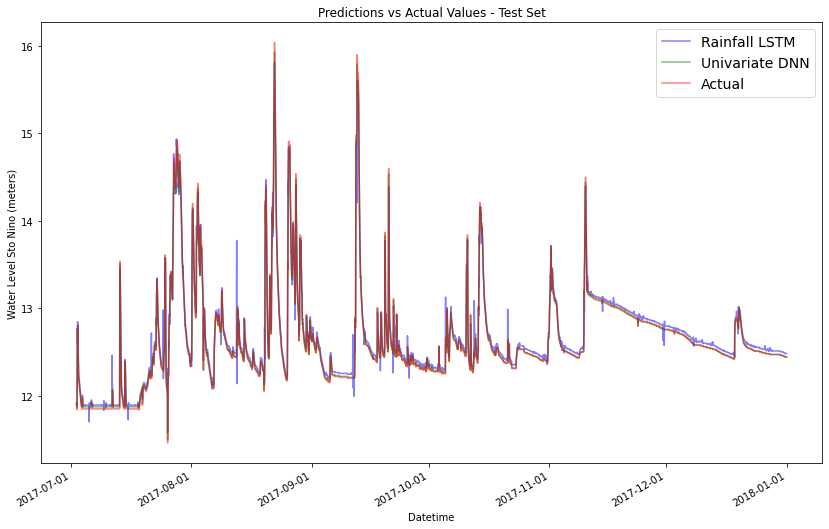

In [143]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.figure(figsize=(14, 9))  # Adjust the width and height as needed
plt.plot(test_dates, lstm_predictions_multi_ann_rainfall_only, c = "blue", label = "Rainfall LSTM", alpha = 0.5)
plt.plot(test_dates, dnn_predictions_univariate_ann, c = "green", label = "Univariate DNN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(test_dates, actual, c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - Test Set')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis major locator to show ticks for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Format the dates as YYYY-MM-DD
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.gcf().autofmt_xdate()
plt.gca().xaxis_date()
plt.legend(prop={'size': 14})  # Change the size value as needed
plt.show()

In [123]:
dnn_predictions_univariate_ann

array([11.911692, 11.892323, 11.872957, ..., 12.444305, 12.444305,
       12.444305], dtype=float32)

In [124]:
lstm_predictions_multi_ann_rainfall_only

array([11.914163, 11.896237, 11.885884, ..., 12.482856, 12.482852,
       12.482851], dtype=float32)

In [125]:
actual

13140    11.89
13141    11.87
13142    11.85
13143    11.84
13144    11.84
         ...  
17515    12.44
17516    12.44
17517    12.44
17518    12.44
17519    12.44
Name: Waterlevel_Sto_Nino, Length: 4380, dtype: float64

In [128]:
test_dates

13140   2017-07-02 12:00:00
13141   2017-07-02 13:00:00
13142   2017-07-02 14:00:00
13143   2017-07-02 15:00:00
13144   2017-07-02 16:00:00
                ...        
17515   2017-12-31 19:00:00
17516   2017-12-31 20:00:00
17517   2017-12-31 21:00:00
17518   2017-12-31 22:00:00
17519   2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: datetime64[ns]

In [129]:
ann_predictions = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual,
    'Rainfall_ANN': lstm_predictions_multi_ann_rainfall_only,
    'Univariate_ANN': dnn_predictions_univariate_ann
})

In [130]:
ann_predictions

,Date,Actual,Rainfall_ANN,Univariate_ANN
13140,2017-07-02 12:00:00,11.89,11.914163,11.911692
13141,2017-07-02 13:00:00,11.87,11.896237,11.892323
13142,2017-07-02 14:00:00,11.85,11.885884,11.872957
13143,2017-07-02 15:00:00,11.84,11.890244,11.863273
13144,2017-07-02 16:00:00,11.84,12.485570,11.863273
...,...,...,...,...
17515,2017-12-31 19:00:00,12.44,12.482866,12.444305
17516,2017-12-31 20:00:00,12.44,12.482859,12.444305
17517,2017-12-31 21:00:00,12.44,12.482856,12.444305
17518,2017-12-31 22:00:00,12.44,12.482852,12.444305


In [131]:
ann_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 13140 to 17519
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            4380 non-null   datetime64[ns]
 1   Actual          4380 non-null   float64       
 2   Rainfall_ANN    4380 non-null   float32       
 3   Univariate_ANN  4380 non-null   float32       
dtypes: datetime64[ns](1), float32(2), float64(1)
memory usage: 102.8 KB


In [132]:
df_sorted = ann_predictions.sort_values(by='Actual', ascending=False)

# To see the highest actual water levels and corresponding predictions
print("Top 10 highest water levels and their predictions:")
print(df_sorted.head(30))

Top 10 highest water levels and their predictions:
                     Date  Actual  Rainfall_ANN  Univariate_ANN
14361 2017-08-22 09:00:00   16.04     15.811349       15.930516
14362 2017-08-22 10:00:00   16.01     15.782442       15.901463
14360 2017-08-22 08:00:00   15.90     15.678355       15.794941
14871 2017-09-12 15:00:00   15.90     15.399997       15.794941
14363 2017-08-22 11:00:00   15.87     15.652169       15.765889
14872 2017-09-12 16:00:00   15.82     15.609601       15.717468
14877 2017-09-12 21:00:00   15.70     15.476137       15.601262
14878 2017-09-12 22:00:00   15.68     15.460105       15.581896
14364 2017-08-22 12:00:00   15.66     15.461555       15.562526
14876 2017-09-12 20:00:00   15.65     15.429883       15.552842
14359 2017-08-22 07:00:00   15.64     15.585851       15.543159
14873 2017-09-12 17:00:00   15.62     15.449118       15.523791
14879 2017-09-12 23:00:00   15.59     15.380757       15.494738
14875 2017-09-12 19:00:00   15.57     15.358048      

In [134]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [136]:
start_date = pd.to_datetime('2017-08-22 00:00:00')
end_date = pd.to_datetime('2017-08-23 00:00:00')

ann_predictions_1 = ann_predictions[(ann_predictions['Date'] >= start_date) & (ann_predictions['Date'] <= end_date)]

In [137]:
ann_predictions_1

,Date,Actual,Rainfall_ANN,Univariate_ANN
14352,2017-08-22 00:00:00,14.11,14.045575,14.061519
14353,2017-08-22 01:00:00,14.24,14.069823,14.187410
14354,2017-08-22 02:00:00,14.33,14.126916,14.274567
14355,2017-08-22 03:00:00,14.50,14.120181,14.439194
14356,2017-08-22 04:00:00,14.93,14.449399,14.855602
14357,2017-08-22 05:00:00,15.20,15.147470,15.117067
14358,2017-08-22 06:00:00,15.39,15.278255,15.301062
14359,2017-08-22 07:00:00,15.64,15.585851,15.543159
14360,2017-08-22 08:00:00,15.90,15.678355,15.794941
14361,2017-08-22 09:00:00,16.04,15.811349,15.930516


In [138]:
start_date = pd.to_datetime('2017-08-22 00:00:00')
end_date = pd.to_datetime('2017-09-22 00:00:00')
ann_predictions_2 = ann_predictions[(ann_predictions['Date'] >= start_date) & (ann_predictions['Date'] <= end_date)]

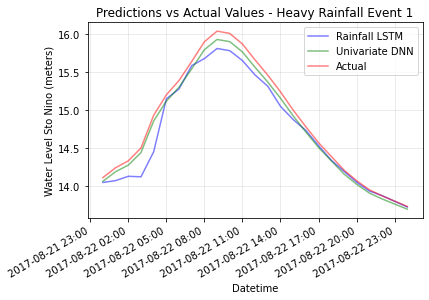

In [141]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.plot(ann_predictions_1['Date'], ann_predictions_1['Rainfall_ANN'], c = "blue", label = "Rainfall LSTM", alpha = 0.5)
plt.plot(ann_predictions_1['Date'], ann_predictions_1['Univariate_ANN'], c = "green", label = "Univariate DNN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(ann_predictions_1['Date'], ann_predictions_1['Actual'], c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - Heavy Rainfall Event 1')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis to show hourly ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Show every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))  # Format as YYYY-MM-DD HH:00

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Add gridlines for better readability of hourly intervals
plt.grid(True, alpha=0.3)

plt.legend()
plt.show()

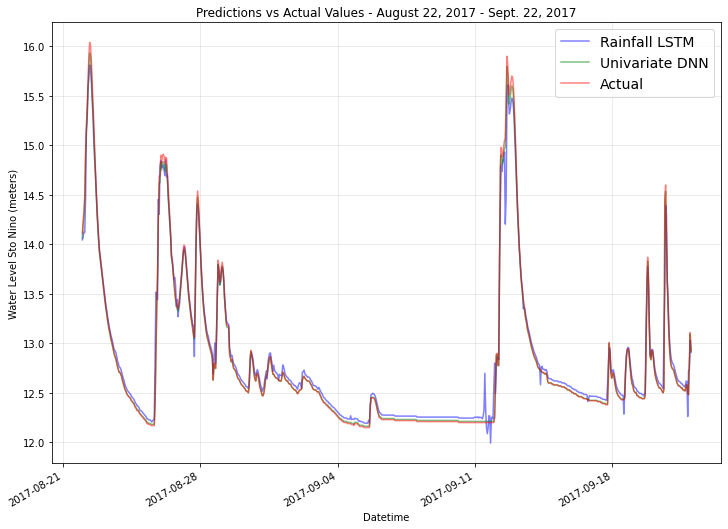

In [142]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.figure(figsize=(12, 9))  # Adjust the width and height as needed

plt.plot(ann_predictions_2['Date'], ann_predictions_2['Rainfall_ANN'], c = "blue", label = "Rainfall LSTM", alpha = 0.5)
plt.plot(ann_predictions_2['Date'], ann_predictions_2['Univariate_ANN'], c = "green", label = "Univariate DNN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(ann_predictions_2['Date'], ann_predictions_2['Actual'], c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - August 22, 2017 - Sept. 22, 2017')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis to show weekly intervals using AutoDateLocator
locator = mdates.AutoDateLocator(interval_multiples=False)
formatter = mdates.AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Add gridlines for better readability of hourly intervals
plt.grid(True, alpha=0.3)

plt.legend(prop={'size': 14})  # Change the size value as needed
plt.show()